# Film Negative Converter

This notebook converts film negatives to positive images with different conversion presets similar to Negative Lab Pro.

In [7]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage import exposure, color, filters
from ipywidgets import interact, widgets

## Step 1: Load the Test Image

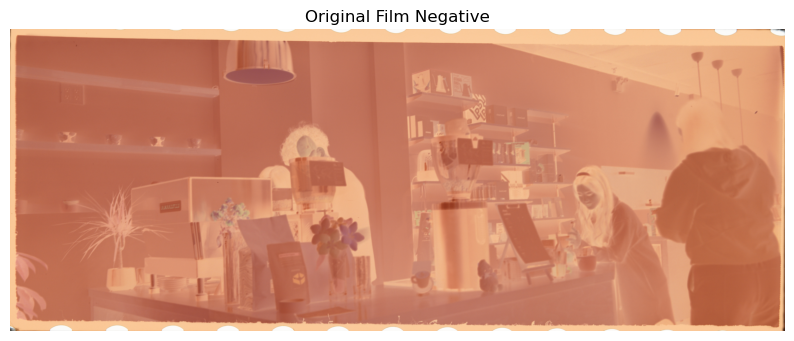

In [8]:
# Load the test image
test_img_path = 'test.JPG'
negative = cv2.imread(test_img_path)
negative = cv2.cvtColor(negative, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Display the original negative
plt.figure(figsize=(10, 8))
plt.imshow(negative)
plt.title('Original Film Negative')
plt.axis('off')
plt.show()

## Step 2: Film Border Detection and Base Color Extraction

In [9]:
def detect_film_border(image, threshold_value=20, min_border_width=10):
    """Detect the film border and extract the base color"""
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply threshold to separate the film from border
    _, binary = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Apply morphological operations to clean up the binary image
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None, None, None
    
    # Get the largest contour (should be the film itself)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Create a mask for the film
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], 0, 255, -1)
    
    # Create a border mask (area outside but close to the film)
    border_mask = np.zeros_like(gray)
    cv2.drawContours(border_mask, [largest_contour], 0, 255, min_border_width)
    border_mask = border_mask - mask
    
    # Get the film base color from the border
    border_pixels = image[border_mask > 0]
    if len(border_pixels) > 0:
        film_base_color = np.median(border_pixels, axis=0)
    else:
        film_base_color = np.array([0, 0, 0])
    
    # Get the bounding box of the film area
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    return mask, film_base_color, (x, y, w, h)

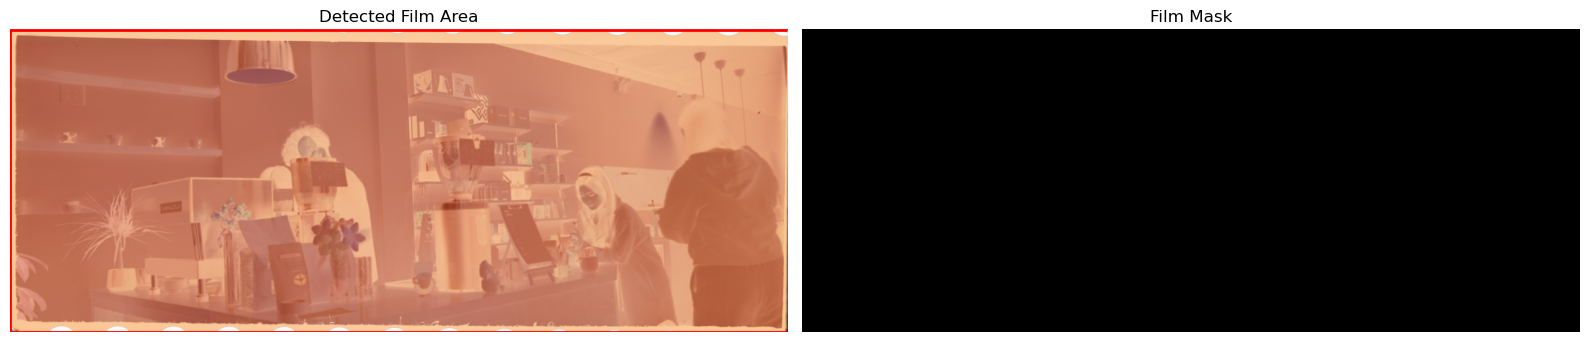

Detected film base color (RGB): [199. 123.  99.]


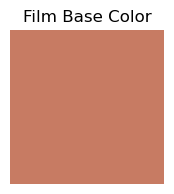

In [10]:
# Apply the film border detection
film_mask, film_base_color, film_bbox = detect_film_border(negative)

# Display the results
if film_mask is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original image with bounding box
    axes[0].imshow(negative)
    if film_bbox:
        x, y, w, h = film_bbox
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[0].add_patch(rect)
    axes[0].set_title('Detected Film Area')
    axes[0].axis('off')
    
    # Film mask
    axes[1].imshow(film_mask, cmap='gray')
    axes[1].set_title('Film Mask')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display the detected film base color
    print(f"Detected film base color (RGB): {film_base_color}")
    
    # Visualize the detected film base color
    color_patch = np.ones((100, 100, 3), dtype=np.uint8)
    color_patch[:, :] = film_base_color
    plt.figure(figsize=(2, 2))
    plt.imshow(color_patch)
    plt.title('Film Base Color')
    plt.axis('off')
    plt.show()
else:
    print("Could not detect film border.")

## Step 3: Negative to Positive Conversion Algorithm

In [11]:
def convert_negative_to_positive(negative_img, film_base_color, preset='standard'):
    """Convert negative to positive using the film base color as reference"""
    # Make a copy of the image to avoid modifying the original
    img = negative_img.copy().astype(np.float32) / 255.0
    
    # Normalize film base color to 0-1 range
    base_color = film_base_color.astype(np.float32) / 255.0
    
    # Invert the image
    img = 1.0 - img
    
    # Apply different presets
    if preset == 'standard':
        # Standard conversion with auto white balance
        for c in range(3):
            if base_color[c] > 0:
                img[:,:,c] = img[:,:,c] / base_color[c]
        
        # Auto contrast stretch - process each channel separately
        for c in range(3):
            p2, p98 = np.percentile(img[:,:,c], (2, 98))
            img[:,:,c] = exposure.rescale_intensity(img[:,:,c], in_range=(p2, p98), out_range=(0, 1))
    
    elif preset == 'frontier':
        # Frontier conversion - warmer tones, higher contrast
        for c in range(3):
            if base_color[c] > 0:
                img[:,:,c] = img[:,:,c] / base_color[c]
        
        # Warm color balance adjustment
        img[:,:,0] *= 1.1  # Increase red
        img[:,:,2] *= 0.9  # Decrease blue
        
        # Higher contrast
        img = exposure.adjust_gamma(img, 1.2)
        
        # Process each channel separately for adaptive equalization
        for c in range(3):
            img[:,:,c] = exposure.equalize_adapthist(img[:,:,c], clip_limit=0.03)
    
    elif preset == 'noritsu':
        # Noritsu conversion - neutral tones, more saturated
        for c in range(3):
            if base_color[c] > 0:
                img[:,:,c] = img[:,:,c] / base_color[c]
                
        # Neutral color balance - process each channel separately
        for c in range(3):
            img[:,:,c] = exposure.equalize_hist(img[:,:,c])
        
        # Increase saturation
        hsv = color.rgb2hsv(img)
        hsv[:,:,1] *= 1.2  # Increase saturation
        img = color.hsv2rgb(hsv)
    
    elif preset == 'hasselblad':
        # Hasselblad X5 - high dynamic range, clean colors
        for c in range(3):
            if base_color[c] > 0:
                img[:,:,c] = img[:,:,c] / base_color[c]
        
        # Enhanced dynamic range - process each channel separately
        for c in range(3):
            img[:,:,c] = exposure.rescale_intensity(img[:,:,c], in_range=(0.05, 0.95), out_range=(0, 1))
        
        # Slight blue shift for Hasselblad look
        img[:,:,2] *= 1.1
        
        # Fine contrast adjustment
        img = exposure.adjust_sigmoid(img, cutoff=0.5, gain=10)
    
    # Clip values to ensure they're in the valid range
    img = np.clip(img, 0, 1)
    
    # Convert back to 0-255 range
    img = (img * 255).astype(np.uint8)
    
    return img

## Step 4: Apply Different Presets

In [12]:
# Apply different presets and display results
if film_mask is not None and film_bbox is not None:
    # Extract the film area
    x, y, w, h = film_bbox
    film_area = negative[y:y+h, x:x+w]
    
    # Create different preset conversions
    presets = ['standard', 'frontier', 'noritsu', 'hasselblad']
    converted_images = {}
    
    for preset in presets:
        converted = convert_negative_to_positive(film_area, film_base_color, preset=preset)
        converted_images[preset] = converted
    
    # Display all presets
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, preset in enumerate(presets):
        axes[i].imshow(converted_images[preset])
        axes[i].set_title(f'{preset.capitalize()} Preset')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot convert image: Film area not detected.")

ValueError: Images of type float must be between -1 and 1.

## Step 5: Interactive Preset Selector with Fine-tuning Controls

In [ ]:
# Define a function for the interactive interface
def interactive_converter(preset, contrast=1.0, saturation=1.0, brightness=1.0, highlight_recovery=0.0):
    if film_mask is not None and film_bbox is not None:
        # Extract the film area
        x, y, w, h = film_bbox
        film_area = negative[y:y+h, x:x+w]
        
        # Apply the preset conversion
        converted = convert_negative_to_positive(film_area, film_base_color, preset=preset)
        
        # Apply additional adjustments
        converted = converted.astype(np.float32) / 255.0
        
        # Adjust contrast
        converted = exposure.adjust_gamma(converted, 1.0/contrast)
        
        # Adjust saturation
        hsv = color.rgb2hsv(converted)
        hsv[:,:,1] *= saturation
        converted = color.hsv2rgb(hsv)
        
        # Adjust brightness
        converted = exposure.adjust_gamma(converted, 1.0/brightness)
        
        # Highlight recovery (reduce highlight intensity)
        if highlight_recovery > 0:
            highlights = converted > 0.9
            converted[highlights] = converted[highlights] - (converted[highlights] - 0.9) * highlight_recovery
        
        # Clip and convert back
        converted = np.clip(converted, 0, 1)
        converted = (converted * 255).astype(np.uint8)
        
        # Display the result
        plt.figure(figsize=(10, 8))
        plt.imshow(converted)
        plt.title(f'{preset.capitalize()} Preset')
        plt.axis('off')
        plt.show()
        
        return converted
    else:
        print("Cannot convert image: Film area not detected.")
        return None

In [ ]:
# Create the interactive interface
if film_mask is not None and film_bbox is not None:
    interact(
        interactive_converter,
        preset=widgets.Dropdown(
            options=['standard', 'frontier', 'noritsu', 'hasselblad'],
            value='standard',
            description='Preset:'
        ),
        contrast=widgets.FloatSlider(min=0.5, max=2.0, step=0.1, value=1.0, description='Contrast:'),
        saturation=widgets.FloatSlider(min=0.5, max=2.0, step=0.1, value=1.0, description='Saturation:'),
        brightness=widgets.FloatSlider(min=0.5, max=2.0, step=0.1, value=1.0, description='Brightness:'),
        highlight_recovery=widgets.FloatSlider(min=0.0, max=1.0, step=0.1, value=0.0, description='Highlight Recovery:')
    )
else:
    print("Cannot create interactive interface: Film area not detected.")

## Step 6: Save Final Converted Image

In [ ]:
def save_converted_image(preset='standard', contrast=1.0, saturation=1.0, brightness=1.0, 
                         highlight_recovery=0.0, output_path=None):
    """Save the converted image with the specified preset and adjustments"""
    # Apply the conversion with interactive parameters
    converted = interactive_converter(preset, contrast, saturation, brightness, highlight_recovery)
    
    if converted is None:
        return
    
    # Generate output path if not provided
    if output_path is None:
        output_path = f'converted_{preset}_{test_img_path}'
    
    # Save the image
    plt.imsave(output_path, converted)
    print(f"Converted image saved to {output_path}")
    
    return output_path

In [ ]:
# Example: Save an image with the Frontier preset
# save_converted_image(preset='frontier', contrast=1.2, saturation=1.1, 
#                     output_path='frontier_converted.jpg') 